In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv') 
movies = pd.read_csv('ml-latest-small/movies.csv')
print(ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [3]:
user_ids = ratings['userId'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = ratings['movieId'].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movieencoded2movie = {i: x for i, x in enumerate(movie_ids)}

ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

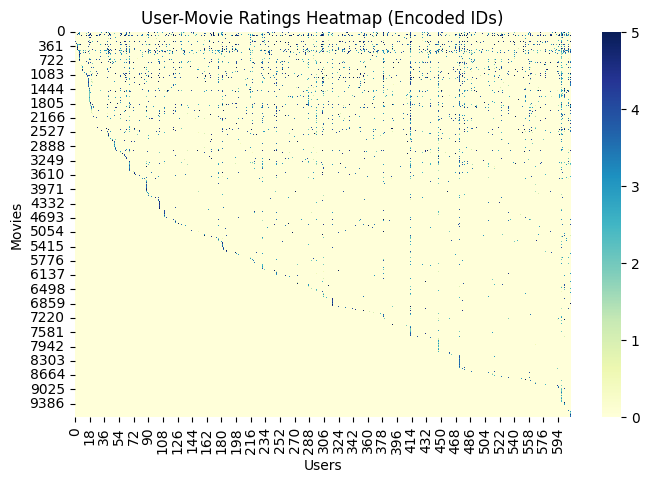

In [14]:
matrix = ratings.pivot(index='movie', columns='user', values='rating').fillna(0)

plt.figure(figsize=(8, 5))
sns.heatmap(matrix, cmap="YlGnBu", cbar=True)
plt.title("User-Movie Ratings Heatmap (Encoded IDs)")
plt.xlabel("Users")
plt.ylabel("Movies")
plt.show()


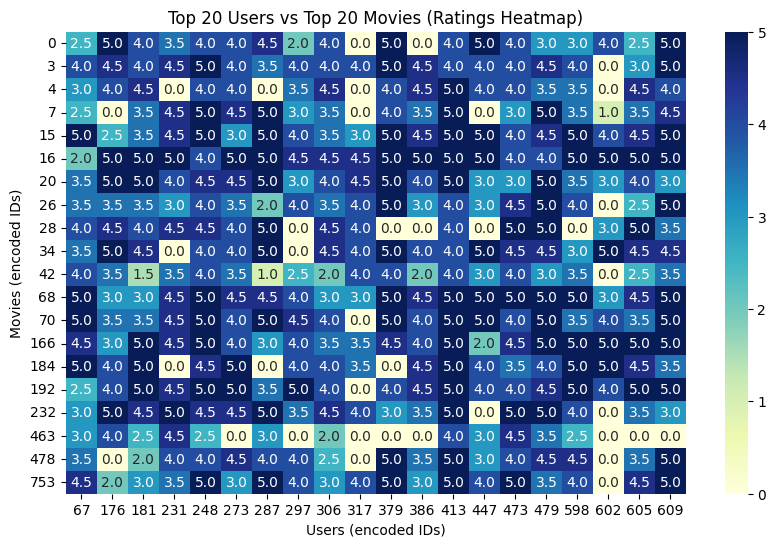

In [5]:
top_users = ratings['user'].value_counts().head(20).index
top_movies = ratings['movie'].value_counts().head(20).index

subset = ratings[ratings['user'].isin(top_users) & ratings['movie'].isin(top_movies)]
matrix_subset = subset.pivot(index='movie', columns='user', values='rating').fillna(0)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, annot=True, fmt=".1f")
plt.title("Top 20 Users vs Top 20 Movies (Ratings Heatmap)")
plt.xlabel("Users (encoded IDs)")
plt.ylabel("Movies (encoded IDs)")
plt.show()


In [6]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Ready: {len(y_train)} training samples, {len(y_val)} validation samples.")
print(f"Users: {num_users}, Movies: {num_movies}")

Data Ready: 80668 training samples, 20168 validation samples.
Users: 610, Movies: 9724


In [7]:
EMBEDDING_SIZE = 50

user_input = layers.Input(shape=(1,), name='user_input')
user_embedding = layers.Embedding(num_users, EMBEDDING_SIZE, name='user_embedding')(user_input)
user_vec = layers.Flatten(name='flatten_users')(user_embedding)

movie_input = layers.Input(shape=(1,), name='movie_input')
movie_embedding = layers.Embedding(num_movies, EMBEDDING_SIZE, name='movie_embedding')(movie_input)
movie_vec = layers.Flatten(name='flatten_movies')(movie_embedding)

prod = layers.Dot(axes=1)([user_vec, movie_vec])

output = layers.Activation('sigmoid')(prod)

model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 50)             │          30,500 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_embedding (Embedding)   │ (None, 1, 50)             │         486,200 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_users (Flatten)       │ (None, 50)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_movies (Flatten)      │ (None, 50)                │               0 │ movie_embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dot (Dot)                     │ (None, 1)                 │               0 │ flatten_users[0][0],       │
│                               │                           │                 │ flatten_movies[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 1)                 │               0 │ dot[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 516,700 (1.97 MB)

 Trainable params: 516,700 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    x=[x_train[:, 0], x_train[:, 1]], 
    y=y_train,                        
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val)
)

Epoch 1/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6729 - val_loss: 0.6239
Epoch 2/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6039 - val_loss: 0.6042
Epoch 3/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5823 - val_loss: 0.6006
Epoch 4/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5664 - val_loss: 0.6002
Epoch 5/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5540 - val_loss: 0.6011


In [12]:
user_id_to_check = ratings.userId.sample(1).iloc[0]
encoded_user_id = user2user_encoded[user_id_to_check]


watched_movies = ratings[ratings.userId == user_id_to_check].movieId
all_movies = movies.movieId.values
movies_not_watched = list(set(all_movies) - set(watched_movies))

movies_not_watched_encoded = [[movie2movie_encoded.get(x)] for x in movies_not_watched if x in movie2movie_encoded]
user_encoder_array = np.array([[encoded_user_id]] * len(movies_not_watched_encoded))
movies_not_watched_encoded = np.array(movies_not_watched_encoded)


predictions = model.predict([user_encoder_array, movies_not_watched_encoded])

ratings_preds = predictions.flatten()


top_indices = ratings_preds.argsort()[-10:][::-1]

recommended_movie_ids = [movieencoded2movie[movies_not_watched_encoded[x][0]] for x in top_indices]

print(f"\n--- Recommendations for User {user_id_to_check} ---")
print("Top 10 Movies you haven't seen yet:")
print("-" * 40)
for m_id in recommended_movie_ids:
    title = movies[movies.movieId == m_id].title.values[0]
    print(title)

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Recommendations for User 305 ---
Top 10 Movies you haven't seen yet:
----------------------------------------
Streetcar Named Desire, A (1951)
Celebration, The (Festen) (1998)
Dogville (2003)
Princess Mononoke (Mononoke-hime) (1997)
Moonrise Kingdom (2012)
Gladiator (1992)
Witness for the Prosecution (1957)
Paperman (2012)
Casablanca (1942)
Captain Phillips (2013)
